# Nuclear Mass Neural Net

This short tensorflow toy trains a standard neural network to output binding energy based on an input neutron and proton number. The first code block uses a saved model and should stand by itself, but the training stuff is down below.

Also included are a couple of widgets. Be sure to run the first cell first to define some functions, then the widgets should run fine provided you have the environment set up correctly.

In [66]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)

# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# input N,Z return model estimated binding energy
def BE(N, Z):
    # Hard code the data averages
    zm=55.16940328394073
    nm=76.95234281137365
    Zs=(Z - zm) / zm
    Ns=(N - nm) / nm

    nucleus=np.array([[Zs,Ns]])

    [[BE]] = model.predict(nucleus,verbose=0)
    return BE

def GenerateMasses():
    zm=55.16940328394073
    nm=76.95234281137365
    nuclei=[[0,0]]
    for zi in range(1,120):
        Zs=(zi - zm) / zm
        for ni in range(0,160):
            Ns=(ni - nm) / nm
            nuclei=np.append(nuclei,[[Zs,Ns]],axis=0)
            
    energies=model.predict(nuclei,verbose=0)
    nuclei[:,0]=nuclei[:,0]*zm+zm
    nuclei[:,1]=nuclei[:,1]*nm+nm
    a_sum=np.sum(nuclei,axis=1)
    return pd.DataFrame({'A':a_sum,'Z':nuclei[:,0],'N':nuclei[:,1],'Energies':energies[:,0]*a_sum[:]})

def CalcSepEn(Z,A1,A2):
    Nucleus=predicted.loc[lambda predicted: predicted.Z==Z, :]
    Nucleus=Nucleus.loc[(Nucleus['A'] >= A1) & (Nucleus['A'] <= A2)]
    Nucleus['NeutronSeparationEnergies'] = Nucleus['Energies'].diff(+1)
    return Nucleus

    
# Given a Z value and number of separation, add neutron separation energies for the nucleus
#def NSepEn(Z,nsep,df):
#    for N in range[0:2*Z]:
        
# load our pretrained model
massmodel = tf.keras.models.load_model('neuralmasses.h5', custom_objects={'R2': R2})

# Generate a massive mass chart
predicted=GenerateMasses()

## Separation energy widget

Input a proton number and bounds for total A and watch what the neural net predicts. Note, some experimental data may have been used in the training! 

In [68]:
from ipywidgets import interactive,interact_manual
def f(Z,A1,A2):
    Nucleus=CalcSepEn(int(Z),int(A1),int(A2))
    MakePlot([Nucleus.A], [Nucleus.NeutronSeparationEnergies], ['b'], ['Neutron Separation Energy'], ['$A$','$S_n$'])
    plt.show()

interactive_plot = interact_manual(f, Z="Input Proton Number", A1="Input Minimum A", A2="Input Maximum A")

interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Minimum A', descri…

## Binding energy widget

Input Z and N to see what the neural net predicts for the binding energy.

In [71]:
from ipywidgets import interactive,interact_manual
def f(Z,N):
    A=int(Z)+int(N)
    pBE=BE(int(N),int(Z))
    print("Binding Energy per Nucleon:",pBE)
    print("Total Binding Energy:",pBE*A)

interactive = interact_manual(f, Z="Input Proton Number", N="Input Neutron Number")


interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Neutron Number', d…

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Features:
   Shape: (1997, 2)
   Type: float64

Training Targets:
   Shape: (1997,)
   Type: float64

Test Features:
   Shape: (500, 2)
   Type: float64

Test Targets:
   Shape: (500,)
   Type: float64

Train on 1597 samples, validate on 400 samples
Epoch 1/5000
1597/1597 [==============================] - 1s 729us/sample - loss: 63.6837 - R2: -362.7517 - val_loss: 61.5403 - val_R2: -353.3869
Epoch 2/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 56.6504 - R2: -338.7555 - val_loss: 50.0197 - val_R2: -275.4555
Epoch 3/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 37.9708 - R2: -229.9243 - val_loss: 24.6041 - val_R2: -140.8645
Epoch 4/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 13.5092 - R2: -70.3876 - val_loss: 7.6973 - val_R2: -35.0699
Epoch 5/5000
1597/1597 [==============================] - 0s 262us/sample - loss: 6.5581 - R2: -28.5635 - val_loss: 5.7231 - val_R2: -26.5406
Epoch 6/5000
1597/

Epoch 58/5000
1597/1597 [==============================] - 0s 220us/sample - loss: 0.1374 - R2: 0.7569 - val_loss: 0.1082 - val_R2: 0.7773
Epoch 59/5000
1597/1597 [==============================] - 0s 221us/sample - loss: 0.1375 - R2: 0.7048 - val_loss: 0.1162 - val_R2: 0.8116
Epoch 60/5000
1597/1597 [==============================] - 0s 233us/sample - loss: 0.1338 - R2: 0.7255 - val_loss: 0.1012 - val_R2: 0.7801
Epoch 61/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.1281 - R2: 0.7234 - val_loss: 0.1109 - val_R2: 0.8508
Epoch 62/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.1324 - R2: 0.7230 - val_loss: 0.1003 - val_R2: 0.8554
Epoch 63/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.1289 - R2: 0.7513 - val_loss: 0.0972 - val_R2: 0.8276
Epoch 64/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.1277 - R2: 0.7243 - val_loss: 0.0933 - val_R2: 0.7909
Epoch 65/5000
1597/1597 [==

Epoch 117/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 0.0935 - R2: 0.7741 - val_loss: 0.0594 - val_R2: 0.9094
Epoch 118/5000
1597/1597 [==============================] - 0s 259us/sample - loss: 0.0936 - R2: 0.7951 - val_loss: 0.0579 - val_R2: 0.9212
Epoch 119/5000
1597/1597 [==============================] - 0s 221us/sample - loss: 0.0963 - R2: 0.7960 - val_loss: 0.0457 - val_R2: 0.9004
Epoch 120/5000
1597/1597 [==============================] - 0s 272us/sample - loss: 0.0898 - R2: 0.7828 - val_loss: 0.0467 - val_R2: 0.9134
Epoch 121/5000
1597/1597 [==============================] - 0s 259us/sample - loss: 0.0933 - R2: 0.7925 - val_loss: 0.0598 - val_R2: 0.8113
Epoch 122/5000
1597/1597 [==============================] - 0s 222us/sample - loss: 0.0943 - R2: 0.7798 - val_loss: 0.0471 - val_R2: 0.9110
Epoch 123/5000
1597/1597 [==============================] - 0s 212us/sample - loss: 0.0910 - R2: 0.8215 - val_loss: 0.0498 - val_R2: 0.9137
Epoch 124/5000
1597/

1597/1597 [==============================] - 0s 246us/sample - loss: 0.0844 - R2: 0.7928 - val_loss: 0.0551 - val_R2: 0.9091
Epoch 176/5000
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0799 - R2: 0.8350 - val_loss: 0.0357 - val_R2: 0.9102
Epoch 177/5000
1597/1597 [==============================] - 0s 220us/sample - loss: 0.0808 - R2: 0.7997 - val_loss: 0.0369 - val_R2: 0.8996
Epoch 178/5000
1597/1597 [==============================] - 0s 216us/sample - loss: 0.0865 - R2: 0.7914 - val_loss: 0.0410 - val_R2: 0.9321
Epoch 179/5000
1597/1597 [==============================] - 0s 212us/sample - loss: 0.0786 - R2: 0.8008 - val_loss: 0.0408 - val_R2: 0.9323
Epoch 180/5000
1597/1597 [==============================] - 0s 223us/sample - loss: 0.0818 - R2: 0.8197 - val_loss: 0.0361 - val_R2: 0.9215
Epoch 181/5000
1597/1597 [==============================] - 0s 233us/sample - loss: 0.0784 - R2: 0.8041 - val_loss: 0.0382 - val_R2: 0.9085
Epoch 182/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 248us/sample - loss: 0.0768 - R2: 0.8161 - val_loss: 0.0317 - val_R2: 0.9094
Epoch 234/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0751 - R2: 0.7863 - val_loss: 0.0367 - val_R2: 0.9205
Epoch 235/5000
1597/1597 [==============================] - 0s 213us/sample - loss: 0.0736 - R2: 0.8311 - val_loss: 0.0371 - val_R2: 0.9319
Epoch 236/5000
1597/1597 [==============================] - 0s 221us/sample - loss: 0.0745 - R2: 0.8314 - val_loss: 0.0310 - val_R2: 0.9252
Epoch 237/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0764 - R2: 0.8348 - val_loss: 0.0391 - val_R2: 0.9236
Epoch 238/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0737 - R2: 0.8397 - val_loss: 0.0317 - val_R2: 0.9012
Epoch 239/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0783 - R2: 0.8044 - val_loss: 0.0343 - val_R2: 0.9003
Epoch 240/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 234us/sample - loss: 0.0689 - R2: 0.8470 - val_loss: 0.0438 - val_R2: 0.9360
Epoch 292/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0634 - R2: 0.8433 - val_loss: 0.0262 - val_R2: 0.9365
Epoch 293/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0707 - R2: 0.8386 - val_loss: 0.0347 - val_R2: 0.9411
Epoch 294/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0716 - R2: 0.7837 - val_loss: 0.0407 - val_R2: 0.8764
Epoch 295/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0699 - R2: 0.8579 - val_loss: 0.0293 - val_R2: 0.9207
Epoch 296/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0684 - R2: 0.8138 - val_loss: 0.0281 - val_R2: 0.9131
Epoch 297/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0680 - R2: 0.8385 - val_loss: 0.0292 - val_R2: 0.9096
Epoch 298/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 243us/sample - loss: 0.0602 - R2: 0.8683 - val_loss: 0.0233 - val_R2: 0.9582
Epoch 350/5000
1597/1597 [==============================] - 0s 233us/sample - loss: 0.0573 - R2: 0.8802 - val_loss: 0.0229 - val_R2: 0.9336
Epoch 351/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0571 - R2: 0.8443 - val_loss: 0.0218 - val_R2: 0.9564
Epoch 352/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0553 - R2: 0.8849 - val_loss: 0.0349 - val_R2: 0.9554
Epoch 353/5000
1597/1597 [==============================] - 0s 233us/sample - loss: 0.0612 - R2: 0.8670 - val_loss: 0.0228 - val_R2: 0.9489
Epoch 354/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0585 - R2: 0.8910 - val_loss: 0.0306 - val_R2: 0.9490
Epoch 355/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0592 - R2: 0.8757 - val_loss: 0.0268 - val_R2: 0.9465
Epoch 356/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 220us/sample - loss: 0.0502 - R2: 0.8933 - val_loss: 0.0236 - val_R2: 0.9627
Epoch 408/5000
1597/1597 [==============================] - 0s 219us/sample - loss: 0.0505 - R2: 0.8810 - val_loss: 0.0318 - val_R2: 0.9529
Epoch 409/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0490 - R2: 0.9017 - val_loss: 0.0203 - val_R2: 0.9636
Epoch 410/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0523 - R2: 0.9034 - val_loss: 0.0203 - val_R2: 0.9664
Epoch 411/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0474 - R2: 0.9200 - val_loss: 0.0201 - val_R2: 0.9699
Epoch 412/5000
1597/1597 [==============================] - 0s 255us/sample - loss: 0.0452 - R2: 0.9108 - val_loss: 0.0220 - val_R2: 0.9651
Epoch 413/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0456 - R2: 0.8833 - val_loss: 0.0166 - val_R2: 0.9626
Epoch 414/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 247us/sample - loss: 0.0418 - R2: 0.9147 - val_loss: 0.0162 - val_R2: 0.9700
Epoch 466/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0407 - R2: 0.8733 - val_loss: 0.0521 - val_R2: 0.9469
Epoch 467/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0463 - R2: 0.9093 - val_loss: 0.0219 - val_R2: 0.9454
Epoch 468/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0440 - R2: 0.9168 - val_loss: 0.0165 - val_R2: 0.9795
Epoch 469/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0428 - R2: 0.8999 - val_loss: 0.0200 - val_R2: 0.9533
Epoch 470/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0443 - R2: 0.8866 - val_loss: 0.0183 - val_R2: 0.9583
Epoch 471/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0385 - R2: 0.9233 - val_loss: 0.0184 - val_R2: 0.9663
Epoch 472/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 251us/sample - loss: 0.0338 - R2: 0.9204 - val_loss: 0.0147 - val_R2: 0.9821
Epoch 524/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0346 - R2: 0.9422 - val_loss: 0.0165 - val_R2: 0.9556
Epoch 525/5000
1597/1597 [==============================] - 0s 220us/sample - loss: 0.0334 - R2: 0.9424 - val_loss: 0.0185 - val_R2: 0.9806
Epoch 526/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0287 - R2: 0.9378 - val_loss: 0.0452 - val_R2: 0.9345
Epoch 527/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0362 - R2: 0.9203 - val_loss: 0.0131 - val_R2: 0.9760
Epoch 528/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0295 - R2: 0.9199 - val_loss: 0.0216 - val_R2: 0.9762
Epoch 529/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0334 - R2: 0.9291 - val_loss: 0.0156 - val_R2: 0.9786
Epoch 530/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 239us/sample - loss: 0.0299 - R2: 0.9206 - val_loss: 0.0321 - val_R2: 0.9709
Epoch 582/5000
1597/1597 [==============================] - 0s 223us/sample - loss: 0.0287 - R2: 0.9220 - val_loss: 0.0402 - val_R2: 0.9216
Epoch 583/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0289 - R2: 0.9261 - val_loss: 0.0182 - val_R2: 0.9826
Epoch 584/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0258 - R2: 0.9435 - val_loss: 0.0123 - val_R2: 0.9754
Epoch 585/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0265 - R2: 0.9315 - val_loss: 0.0165 - val_R2: 0.9620
Epoch 586/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0319 - R2: 0.9283 - val_loss: 0.0156 - val_R2: 0.9577
Epoch 587/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0275 - R2: 0.9416 - val_loss: 0.0134 - val_R2: 0.9786
Epoch 588/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 240us/sample - loss: 0.0304 - R2: 0.9223 - val_loss: 0.0213 - val_R2: 0.9814
Epoch 640/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0253 - R2: 0.9538 - val_loss: 0.0110 - val_R2: 0.9842
Epoch 641/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0276 - R2: 0.9268 - val_loss: 0.0121 - val_R2: 0.9739
Epoch 642/5000
1597/1597 [==============================] - 0s 265us/sample - loss: 0.0246 - R2: 0.9555 - val_loss: 0.0158 - val_R2: 0.9815
Epoch 643/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0234 - R2: 0.9297 - val_loss: 0.0483 - val_R2: 0.9538
Epoch 644/5000
1597/1597 [==============================] - 0s 277us/sample - loss: 0.0368 - R2: 0.9445 - val_loss: 0.0143 - val_R2: 0.9826
Epoch 645/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0285 - R2: 0.9576 - val_loss: 0.0142 - val_R2: 0.9743
Epoch 646/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 239us/sample - loss: 0.0306 - R2: 0.9360 - val_loss: 0.0163 - val_R2: 0.9627
Epoch 698/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0298 - R2: 0.9308 - val_loss: 0.0124 - val_R2: 0.9881
Epoch 699/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0254 - R2: 0.9580 - val_loss: 0.0150 - val_R2: 0.9793
Epoch 700/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0230 - R2: 0.9403 - val_loss: 0.0148 - val_R2: 0.9818
Epoch 701/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0264 - R2: 0.9403 - val_loss: 0.0183 - val_R2: 0.9742
Epoch 702/5000
1597/1597 [==============================] - 0s 255us/sample - loss: 0.0210 - R2: 0.9592 - val_loss: 0.0191 - val_R2: 0.9672
Epoch 703/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0271 - R2: 0.9216 - val_loss: 0.0215 - val_R2: 0.9296
Epoch 704/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 277us/sample - loss: 0.0271 - R2: 0.9495 - val_loss: 0.0135 - val_R2: 0.9841
Epoch 756/5000
1597/1597 [==============================] - 0s 261us/sample - loss: 0.0273 - R2: 0.9406 - val_loss: 0.0151 - val_R2: 0.9861
Epoch 757/5000
1597/1597 [==============================] - 0s 260us/sample - loss: 0.0221 - R2: 0.9419 - val_loss: 0.0089 - val_R2: 0.9826
Epoch 758/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0186 - R2: 0.9352 - val_loss: 0.0118 - val_R2: 0.9800
Epoch 759/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0242 - R2: 0.9604 - val_loss: 0.0184 - val_R2: 0.9765
Epoch 760/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0213 - R2: 0.9651 - val_loss: 0.0094 - val_R2: 0.9746
Epoch 761/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0304 - R2: 0.9232 - val_loss: 0.0178 - val_R2: 0.9801
Epoch 762/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 238us/sample - loss: 0.0235 - R2: 0.9272 - val_loss: 0.0203 - val_R2: 0.9762
Epoch 814/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0203 - R2: 0.9628 - val_loss: 0.0120 - val_R2: 0.9813
Epoch 815/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0188 - R2: 0.9416 - val_loss: 0.0153 - val_R2: 0.9842
Epoch 816/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0145 - R2: 0.9731 - val_loss: 0.0072 - val_R2: 0.9880
Epoch 817/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0210 - R2: 0.9680 - val_loss: 0.0118 - val_R2: 0.9740
Epoch 818/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0250 - R2: 0.9413 - val_loss: 0.0244 - val_R2: 0.9639
Epoch 819/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0207 - R2: 0.9570 - val_loss: 0.0095 - val_R2: 0.9759
Epoch 820/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 233us/sample - loss: 0.0168 - R2: 0.9412 - val_loss: 0.0111 - val_R2: 0.9843
Epoch 872/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0150 - R2: 0.9678 - val_loss: 0.0064 - val_R2: 0.9882
Epoch 873/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0238 - R2: 0.9399 - val_loss: 0.0124 - val_R2: 0.9740
Epoch 874/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0209 - R2: 0.9577 - val_loss: 0.0124 - val_R2: 0.9794
Epoch 875/5000
1597/1597 [==============================] - 0s 255us/sample - loss: 0.0214 - R2: 0.9629 - val_loss: 0.0211 - val_R2: 0.9502
Epoch 876/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0361 - R2: 0.9285 - val_loss: 0.0365 - val_R2: 0.9665
Epoch 877/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0114 - R2: 0.9673 - val_loss: 0.0057 - val_R2: 0.9835
Epoch 878/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 242us/sample - loss: 0.0333 - R2: 0.9368 - val_loss: 0.0178 - val_R2: 0.9582
Epoch 930/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0219 - R2: 0.9540 - val_loss: 0.0081 - val_R2: 0.9877
Epoch 931/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0227 - R2: 0.9404 - val_loss: 0.0062 - val_R2: 0.9858
Epoch 932/5000
1597/1597 [==============================] - 0s 222us/sample - loss: 0.0216 - R2: 0.9643 - val_loss: 0.0246 - val_R2: 0.9815
Epoch 933/5000
1597/1597 [==============================] - 0s 224us/sample - loss: 0.0254 - R2: 0.9598 - val_loss: 0.0319 - val_R2: 0.9296
Epoch 934/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0188 - R2: 0.9640 - val_loss: 0.0238 - val_R2: 0.9723
Epoch 935/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0139 - R2: 0.9605 - val_loss: 0.0383 - val_R2: 0.9675
Epoch 936/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 243us/sample - loss: 0.0172 - R2: 0.9626 - val_loss: 0.0542 - val_R2: 0.9643
Epoch 988/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0137 - R2: 0.9541 - val_loss: 0.0056 - val_R2: 0.9846
Epoch 989/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0204 - R2: 0.9637 - val_loss: 0.0187 - val_R2: 0.9793
Epoch 990/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0153 - R2: 0.9530 - val_loss: 0.0324 - val_R2: 0.9639
Epoch 991/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0144 - R2: 0.9743 - val_loss: 0.0118 - val_R2: 0.9716
Epoch 992/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0310 - R2: 0.9143 - val_loss: 0.0144 - val_R2: 0.9853
Epoch 993/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0211 - R2: 0.9408 - val_loss: 0.0099 - val_R2: 0.9885
Epoch 994/5000
1597/1597 [=========

1597/1597 [==============================] - 0s 241us/sample - loss: 0.0194 - R2: 0.9520 - val_loss: 0.0265 - val_R2: 0.9404
Epoch 1046/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0159 - R2: 0.9647 - val_loss: 0.0107 - val_R2: 0.9839
Epoch 1047/5000
1597/1597 [==============================] - 0s 219us/sample - loss: 0.0149 - R2: 0.9651 - val_loss: 0.0383 - val_R2: 0.9676
Epoch 1048/5000
1597/1597 [==============================] - 0s 221us/sample - loss: 0.0157 - R2: 0.9622 - val_loss: 0.0165 - val_R2: 0.9826
Epoch 1049/5000
1597/1597 [==============================] - 0s 215us/sample - loss: 0.0164 - R2: 0.9659 - val_loss: 0.0076 - val_R2: 0.9831
Epoch 1050/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0108 - R2: 0.9762 - val_loss: 0.0061 - val_R2: 0.9881
Epoch 1051/5000
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0194 - R2: 0.9560 - val_loss: 0.0053 - val_R2: 0.9769
Epoch 1052/5000
1597/1597 [==

1597/1597 [==============================] - 0s 229us/sample - loss: 0.0147 - R2: 0.9522 - val_loss: 0.0856 - val_R2: 0.8803
Epoch 1104/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0205 - R2: 0.9570 - val_loss: 0.0127 - val_R2: 0.9865
Epoch 1105/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0152 - R2: 0.9622 - val_loss: 0.0089 - val_R2: 0.9815
Epoch 1106/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0110 - R2: 0.9654 - val_loss: 0.0321 - val_R2: 0.9335
Epoch 1107/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0353 - R2: 0.9266 - val_loss: 0.0434 - val_R2: 0.8824
Epoch 1108/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0227 - R2: 0.9339 - val_loss: 0.0187 - val_R2: 0.9872
Epoch 1109/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0195 - R2: 0.9221 - val_loss: 0.0142 - val_R2: 0.9709
Epoch 1110/5000
1597/1597 [==

1597/1597 [==============================] - 0s 249us/sample - loss: 0.0107 - R2: 0.9666 - val_loss: 0.0039 - val_R2: 0.9849
Epoch 1162/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0123 - R2: 0.9618 - val_loss: 0.0056 - val_R2: 0.9786
Epoch 1163/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0121 - R2: 0.9534 - val_loss: 0.0140 - val_R2: 0.9867
Epoch 1164/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0102 - R2: 0.9809 - val_loss: 0.0054 - val_R2: 0.9852
Epoch 1165/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0131 - R2: 0.9636 - val_loss: 0.0074 - val_R2: 0.9886
Epoch 1166/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0169 - R2: 0.9717 - val_loss: 0.0136 - val_R2: 0.9647
Epoch 1167/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0149 - R2: 0.9595 - val_loss: 0.0569 - val_R2: 0.9469
Epoch 1168/5000
1597/1597 [==

1597/1597 [==============================] - 0s 214us/sample - loss: 0.0176 - R2: 0.9406 - val_loss: 0.0776 - val_R2: 0.9204
Epoch 1220/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0179 - R2: 0.9674 - val_loss: 0.0141 - val_R2: 0.9857
Epoch 1221/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0183 - R2: 0.9558 - val_loss: 0.0152 - val_R2: 0.9853
Epoch 1222/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0096 - R2: 0.9661 - val_loss: 0.0108 - val_R2: 0.9885
Epoch 1223/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0084 - R2: 0.9717 - val_loss: 0.0161 - val_R2: 0.9846
Epoch 1224/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0152 - R2: 0.9748 - val_loss: 0.0055 - val_R2: 0.9802
Epoch 1225/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0422 - R2: 0.9019 - val_loss: 0.1762 - val_R2: 0.7754
Epoch 1226/5000
1597/1597 [==

1597/1597 [==============================] - 0s 241us/sample - loss: 0.0099 - R2: 0.9786 - val_loss: 0.0153 - val_R2: 0.9853
Epoch 1278/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0085 - R2: 0.9829 - val_loss: 0.0197 - val_R2: 0.9814
Epoch 1279/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0140 - R2: 0.9720 - val_loss: 0.0058 - val_R2: 0.9917
Epoch 1280/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0166 - R2: 0.9717 - val_loss: 0.0195 - val_R2: 0.9812
Epoch 1281/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0111 - R2: 0.9735 - val_loss: 0.0175 - val_R2: 0.9715
Epoch 1282/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0127 - R2: 0.9745 - val_loss: 0.0136 - val_R2: 0.9866
Epoch 1283/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0134 - R2: 0.9490 - val_loss: 0.0061 - val_R2: 0.9839
Epoch 1284/5000
1597/1597 [==

1597/1597 [==============================] - 0s 242us/sample - loss: 0.0134 - R2: 0.9727 - val_loss: 0.0049 - val_R2: 0.9923
Epoch 1336/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0317 - R2: 0.9105 - val_loss: 0.0197 - val_R2: 0.9371
Epoch 1337/5000
1597/1597 [==============================] - 0s 220us/sample - loss: 0.0148 - R2: 0.9648 - val_loss: 0.0079 - val_R2: 0.9899
Epoch 1338/5000
1597/1597 [==============================] - 0s 206us/sample - loss: 0.0069 - R2: 0.9850 - val_loss: 0.0225 - val_R2: 0.9817
Epoch 1339/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0116 - R2: 0.9673 - val_loss: 0.0067 - val_R2: 0.9854
Epoch 1340/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0160 - R2: 0.9563 - val_loss: 0.0163 - val_R2: 0.9815
Epoch 1341/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0110 - R2: 0.9633 - val_loss: 0.0328 - val_R2: 0.9643
Epoch 1342/5000
1597/1597 [==

1597/1597 [==============================] - 0s 219us/sample - loss: 0.0174 - R2: 0.9602 - val_loss: 0.0144 - val_R2: 0.9871
Epoch 1394/5000
1597/1597 [==============================] - 0s 233us/sample - loss: 0.0077 - R2: 0.9840 - val_loss: 0.0061 - val_R2: 0.9913
Epoch 1395/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0109 - R2: 0.9794 - val_loss: 0.0113 - val_R2: 0.9776
Epoch 1396/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0151 - R2: 0.9731 - val_loss: 0.0027 - val_R2: 0.9930
Epoch 1397/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0120 - R2: 0.9669 - val_loss: 0.0108 - val_R2: 0.9890
Epoch 1398/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0082 - R2: 0.9708 - val_loss: 0.0227 - val_R2: 0.9804
Epoch 1399/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0086 - R2: 0.9772 - val_loss: 0.0073 - val_R2: 0.9873
Epoch 1400/5000
1597/1597 [==

1597/1597 [==============================] - 0s 226us/sample - loss: 0.0087 - R2: 0.9732 - val_loss: 0.0078 - val_R2: 0.9869
Epoch 1452/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0076 - R2: 0.9826 - val_loss: 0.0070 - val_R2: 0.9887
Epoch 1453/5000
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0085 - R2: 0.9674 - val_loss: 0.0176 - val_R2: 0.9844
Epoch 1454/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0081 - R2: 0.9793 - val_loss: 0.0108 - val_R2: 0.9901
Epoch 1455/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0296 - R2: 0.9233 - val_loss: 0.0108 - val_R2: 0.9553
Epoch 1456/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0158 - R2: 0.9579 - val_loss: 0.0513 - val_R2: 0.9442
Epoch 1457/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0144 - R2: 0.9689 - val_loss: 0.0115 - val_R2: 0.9582
Epoch 1458/5000
1597/1597 [==

1597/1597 [==============================] - 0s 234us/sample - loss: 0.0363 - R2: 0.9281 - val_loss: 0.0072 - val_R2: 0.9901
Epoch 1510/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0113 - R2: 0.9671 - val_loss: 0.0745 - val_R2: 0.9358
Epoch 1511/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0313 - R2: 0.9462 - val_loss: 0.0170 - val_R2: 0.9860
Epoch 1512/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0244 - R2: 0.9572 - val_loss: 0.0046 - val_R2: 0.9892
Epoch 1513/5000
1597/1597 [==============================] - 0s 223us/sample - loss: 0.0069 - R2: 0.9792 - val_loss: 0.0122 - val_R2: 0.9896
Epoch 1514/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0086 - R2: 0.9844 - val_loss: 0.0194 - val_R2: 0.9838
Epoch 1515/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0076 - R2: 0.9877 - val_loss: 0.0195 - val_R2: 0.9831
Epoch 1516/5000
1597/1597 [==

1597/1597 [==============================] - 0s 268us/sample - loss: 0.0235 - R2: 0.9535 - val_loss: 0.0076 - val_R2: 0.9829
Epoch 1568/5000
1597/1597 [==============================] - 0s 293us/sample - loss: 0.0067 - R2: 0.9776 - val_loss: 0.0111 - val_R2: 0.9891
Epoch 1569/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0081 - R2: 0.9767 - val_loss: 0.0212 - val_R2: 0.9839
Epoch 1570/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0075 - R2: 0.9838 - val_loss: 0.0142 - val_R2: 0.9885
Epoch 1571/5000
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0095 - R2: 0.9739 - val_loss: 0.0184 - val_R2: 0.9760
Epoch 1572/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0114 - R2: 0.9647 - val_loss: 0.0269 - val_R2: 0.9807
Epoch 1573/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0218 - R2: 0.9458 - val_loss: 0.0761 - val_R2: 0.9168
Epoch 1574/5000
1597/1597 [==

1597/1597 [==============================] - 0s 228us/sample - loss: 0.0071 - R2: 0.9756 - val_loss: 0.0033 - val_R2: 0.9882
Epoch 1626/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0439 - R2: 0.9422 - val_loss: 0.0264 - val_R2: 0.9749
Epoch 1627/5000
1597/1597 [==============================] - 0s 256us/sample - loss: 0.0119 - R2: 0.9701 - val_loss: 0.0129 - val_R2: 0.9824
Epoch 1628/5000
1597/1597 [==============================] - 0s 228us/sample - loss: 0.0177 - R2: 0.9639 - val_loss: 0.0075 - val_R2: 0.9875
Epoch 1629/5000
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0080 - R2: 0.9844 - val_loss: 0.0085 - val_R2: 0.9905
Epoch 1630/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0115 - R2: 0.9644 - val_loss: 0.0097 - val_R2: 0.9852
Epoch 1631/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0060 - R2: 0.9780 - val_loss: 0.0046 - val_R2: 0.9846
Epoch 1632/5000
1597/1597 [==

1597/1597 [==============================] - 0s 226us/sample - loss: 0.0057 - R2: 0.9775 - val_loss: 0.0085 - val_R2: 0.9889
Epoch 1684/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0069 - R2: 0.9745 - val_loss: 0.0216 - val_R2: 0.9812
Epoch 1685/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0265 - R2: 0.9561 - val_loss: 0.0204 - val_R2: 0.9787
Epoch 1686/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0097 - R2: 0.9719 - val_loss: 0.0393 - val_R2: 0.9761
Epoch 1687/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0107 - R2: 0.9760 - val_loss: 0.0119 - val_R2: 0.9831
Epoch 1688/5000
1597/1597 [==============================] - 0s 228us/sample - loss: 0.0069 - R2: 0.9816 - val_loss: 0.0116 - val_R2: 0.9851
Epoch 1689/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0119 - R2: 0.9696 - val_loss: 0.0087 - val_R2: 0.9694
Epoch 1690/5000
1597/1597 [==

1597/1597 [==============================] - 0s 238us/sample - loss: 0.0067 - R2: 0.9837 - val_loss: 0.0186 - val_R2: 0.9830
Epoch 1742/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0132 - R2: 0.9587 - val_loss: 0.0081 - val_R2: 0.9854
Epoch 1743/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0224 - R2: 0.9526 - val_loss: 0.0168 - val_R2: 0.9795
Epoch 1744/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0181 - R2: 0.9368 - val_loss: 0.0189 - val_R2: 0.9855
Epoch 1745/5000
1597/1597 [==============================] - 0s 223us/sample - loss: 0.0070 - R2: 0.9772 - val_loss: 0.0095 - val_R2: 0.9836
Epoch 1746/5000
1597/1597 [==============================] - 0s 221us/sample - loss: 0.0074 - R2: 0.9863 - val_loss: 0.0185 - val_R2: 0.9842
Epoch 1747/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0316 - R2: 0.9314 - val_loss: 0.0251 - val_R2: 0.9260
Epoch 1748/5000
1597/1597 [==

1597/1597 [==============================] - 0s 238us/sample - loss: 0.0291 - R2: 0.9345 - val_loss: 0.0075 - val_R2: 0.9907
Epoch 1800/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0066 - R2: 0.9816 - val_loss: 0.0102 - val_R2: 0.9899
Epoch 1801/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0081 - R2: 0.9799 - val_loss: 0.0224 - val_R2: 0.9807
Epoch 1802/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0075 - R2: 0.9770 - val_loss: 0.0205 - val_R2: 0.9839
Epoch 1803/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0111 - R2: 0.9715 - val_loss: 0.0097 - val_R2: 0.9906
Epoch 1804/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0086 - R2: 0.9809 - val_loss: 0.0060 - val_R2: 0.9819
Epoch 1805/5000
1597/1597 [==============================] - 0s 264us/sample - loss: 0.0088 - R2: 0.9712 - val_loss: 0.0107 - val_R2: 0.9906
Epoch 1806/5000
1597/1597 [==

1597/1597 [==============================] - 0s 248us/sample - loss: 0.0313 - R2: 0.9410 - val_loss: 0.0283 - val_R2: 0.9529
Epoch 1858/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0109 - R2: 0.9666 - val_loss: 0.0143 - val_R2: 0.9862
Epoch 1859/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0089 - R2: 0.9700 - val_loss: 0.0222 - val_R2: 0.9846
Epoch 1860/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0063 - R2: 0.9753 - val_loss: 0.0146 - val_R2: 0.9891
Epoch 1861/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0075 - R2: 0.9809 - val_loss: 0.0411 - val_R2: 0.9662
Epoch 1862/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0137 - R2: 0.9769 - val_loss: 0.0055 - val_R2: 0.9914
Epoch 1863/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 0.0076 - R2: 0.9719 - val_loss: 0.0116 - val_R2: 0.9895
Epoch 1864/5000
1597/1597 [==

1597/1597 [==============================] - 0s 237us/sample - loss: 0.0107 - R2: 0.9714 - val_loss: 0.0260 - val_R2: 0.9783
Epoch 1916/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0125 - R2: 0.9773 - val_loss: 0.0080 - val_R2: 0.9877
Epoch 1917/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0210 - R2: 0.9568 - val_loss: 0.0476 - val_R2: 0.9563
Epoch 1918/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0102 - R2: 0.9756 - val_loss: 0.0098 - val_R2: 0.9869
Epoch 1919/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0057 - R2: 0.9780 - val_loss: 0.0100 - val_R2: 0.9903
Epoch 1920/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0063 - R2: 0.9873 - val_loss: 0.0086 - val_R2: 0.9892
Epoch 1921/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0068 - R2: 0.9768 - val_loss: 0.0063 - val_R2: 0.9880
Epoch 1922/5000
1597/1597 [==

1597/1597 [==============================] - 0s 234us/sample - loss: 0.0094 - R2: 0.9699 - val_loss: 0.0044 - val_R2: 0.9832
Epoch 1974/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0111 - R2: 0.9650 - val_loss: 0.0139 - val_R2: 0.9766
Epoch 1975/5000
1597/1597 [==============================] - 0s 223us/sample - loss: 0.0104 - R2: 0.9743 - val_loss: 0.0081 - val_R2: 0.9890
Epoch 1976/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0110 - R2: 0.9699 - val_loss: 0.0085 - val_R2: 0.9876
Epoch 1977/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0115 - R2: 0.9683 - val_loss: 0.0184 - val_R2: 0.9808
Epoch 1978/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0133 - R2: 0.9640 - val_loss: 0.0096 - val_R2: 0.9854
Epoch 1979/5000
1597/1597 [==============================] - 0s 256us/sample - loss: 0.0083 - R2: 0.9739 - val_loss: 0.0202 - val_R2: 0.9822
Epoch 1980/5000
1597/1597 [==

1597/1597 [==============================] - 0s 242us/sample - loss: 0.0061 - R2: 0.9802 - val_loss: 0.0209 - val_R2: 0.9740
Epoch 2032/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0176 - R2: 0.9572 - val_loss: 0.0176 - val_R2: 0.9842
Epoch 2033/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0082 - R2: 0.9821 - val_loss: 0.0155 - val_R2: 0.9865
Epoch 2034/5000
1597/1597 [==============================] - 0s 265us/sample - loss: 0.0053 - R2: 0.9836 - val_loss: 0.0146 - val_R2: 0.9877
Epoch 2035/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.0148 - R2: 0.9690 - val_loss: 0.0135 - val_R2: 0.9510
Epoch 2036/5000
1597/1597 [==============================] - 0s 278us/sample - loss: 0.0092 - R2: 0.9742 - val_loss: 0.0110 - val_R2: 0.9888
Epoch 2037/5000
1597/1597 [==============================] - 0s 266us/sample - loss: 0.0063 - R2: 0.9798 - val_loss: 0.0124 - val_R2: 0.9855
Epoch 2038/5000
1597/1597 [==

1597/1597 [==============================] - 0s 227us/sample - loss: 0.0116 - R2: 0.9730 - val_loss: 0.0284 - val_R2: 0.9748
Epoch 2090/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0118 - R2: 0.9754 - val_loss: 0.0072 - val_R2: 0.9892
Epoch 2091/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0084 - R2: 0.9748 - val_loss: 0.0307 - val_R2: 0.9763
Epoch 2092/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0077 - R2: 0.9803 - val_loss: 0.0159 - val_R2: 0.9818
Epoch 2093/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0072 - R2: 0.9861 - val_loss: 0.0132 - val_R2: 0.9889
Epoch 2094/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0063 - R2: 0.9857 - val_loss: 0.0341 - val_R2: 0.9742
Epoch 2095/5000
1597/1597 [==============================] - 0s 256us/sample - loss: 0.0235 - R2: 0.9610 - val_loss: 0.0130 - val_R2: 0.9849
Epoch 2096/5000
1597/1597 [==

1597/1597 [==============================] - 0s 271us/sample - loss: 0.0183 - R2: 0.9594 - val_loss: 0.0606 - val_R2: 0.9426
Epoch 2148/5000
1597/1597 [==============================] - 0s 284us/sample - loss: 0.0200 - R2: 0.9637 - val_loss: 0.0067 - val_R2: 0.9865
Epoch 2149/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0100 - R2: 0.9713 - val_loss: 0.0090 - val_R2: 0.9898
Epoch 2150/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0068 - R2: 0.9774 - val_loss: 0.0116 - val_R2: 0.9859
Epoch 2151/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0083 - R2: 0.9744 - val_loss: 0.0147 - val_R2: 0.9877
Epoch 2152/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0081 - R2: 0.9762 - val_loss: 0.0125 - val_R2: 0.9829
Epoch 2153/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0057 - R2: 0.9783 - val_loss: 0.0207 - val_R2: 0.9854
Epoch 2154/5000
1597/1597 [==

1597/1597 [==============================] - 0s 244us/sample - loss: 0.0060 - R2: 0.9773 - val_loss: 0.0203 - val_R2: 0.9848
Epoch 2206/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0080 - R2: 0.9758 - val_loss: 0.0114 - val_R2: 0.9794
Epoch 2207/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0065 - R2: 0.9778 - val_loss: 0.0084 - val_R2: 0.9869
Epoch 2208/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0098 - R2: 0.9769 - val_loss: 0.0089 - val_R2: 0.9838
Epoch 2209/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0193 - R2: 0.9716 - val_loss: 0.0151 - val_R2: 0.9641
Epoch 2210/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0099 - R2: 0.9712 - val_loss: 0.0214 - val_R2: 0.9804
Epoch 2211/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0064 - R2: 0.9875 - val_loss: 0.0101 - val_R2: 0.9903
Epoch 2212/5000
1597/1597 [==

1597/1597 [==============================] - 0s 245us/sample - loss: 0.0053 - R2: 0.9836 - val_loss: 0.0071 - val_R2: 0.9905
Epoch 2264/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0053 - R2: 0.9895 - val_loss: 0.0343 - val_R2: 0.9790
Epoch 2265/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0059 - R2: 0.9860 - val_loss: 0.0156 - val_R2: 0.9910
Epoch 2266/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0056 - R2: 0.9812 - val_loss: 0.0048 - val_R2: 0.9938
Epoch 2267/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0111 - R2: 0.9733 - val_loss: 0.0056 - val_R2: 0.9908
Epoch 2268/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0046 - R2: 0.9812 - val_loss: 0.0115 - val_R2: 0.9887
Epoch 2269/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0168 - R2: 0.9791 - val_loss: 0.0121 - val_R2: 0.9774
Epoch 2270/5000
1597/1597 [==

1597/1597 [==============================] - 0s 213us/sample - loss: 0.0064 - R2: 0.9758 - val_loss: 0.0157 - val_R2: 0.9856
Epoch 2322/5000
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0058 - R2: 0.9825 - val_loss: 0.0095 - val_R2: 0.9894
Epoch 2323/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0062 - R2: 0.9832 - val_loss: 0.0112 - val_R2: 0.9904
Epoch 2324/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0053 - R2: 0.9795 - val_loss: 0.0115 - val_R2: 0.9890
Epoch 2325/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0054 - R2: 0.9816 - val_loss: 0.0037 - val_R2: 0.9935
Epoch 2326/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0064 - R2: 0.9773 - val_loss: 0.0660 - val_R2: 0.9612
Epoch 2327/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0084 - R2: 0.9774 - val_loss: 0.0152 - val_R2: 0.9854
Epoch 2328/5000
1597/1597 [==

1597/1597 [==============================] - 0s 226us/sample - loss: 0.0061 - R2: 0.9804 - val_loss: 0.0036 - val_R2: 0.9900
Epoch 2380/5000
1597/1597 [==============================] - 0s 264us/sample - loss: 0.0173 - R2: 0.9659 - val_loss: 0.0287 - val_R2: 0.9759
Epoch 2381/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0152 - R2: 0.9672 - val_loss: 0.0064 - val_R2: 0.9779
Epoch 2382/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0487 - R2: 0.9022 - val_loss: 0.0173 - val_R2: 0.9801
Epoch 2383/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0076 - R2: 0.9756 - val_loss: 0.0113 - val_R2: 0.9906
Epoch 2384/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0053 - R2: 0.9878 - val_loss: 0.0135 - val_R2: 0.9904
Epoch 2385/5000
1597/1597 [==============================] - 0s 263us/sample - loss: 0.0080 - R2: 0.9763 - val_loss: 0.0325 - val_R2: 0.9744
Epoch 2386/5000
1597/1597 [==

1597/1597 [==============================] - 0s 253us/sample - loss: 0.0058 - R2: 0.9815 - val_loss: 0.0230 - val_R2: 0.9828
Epoch 2438/5000
1597/1597 [==============================] - 0s 260us/sample - loss: 0.0076 - R2: 0.9792 - val_loss: 0.0203 - val_R2: 0.9878
Epoch 2439/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0084 - R2: 0.9767 - val_loss: 0.0168 - val_R2: 0.9843
Epoch 2440/5000
1597/1597 [==============================] - 0s 261us/sample - loss: 0.0054 - R2: 0.9897 - val_loss: 0.0158 - val_R2: 0.9868
Epoch 2441/5000
1597/1597 [==============================] - 0s 256us/sample - loss: 0.0053 - R2: 0.9786 - val_loss: 0.0044 - val_R2: 0.9922
Epoch 2442/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0051 - R2: 0.9759 - val_loss: 0.0073 - val_R2: 0.9914
Epoch 2443/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0120 - R2: 0.9712 - val_loss: 0.0096 - val_R2: 0.9896
Epoch 2444/5000
1597/1597 [==

1597/1597 [==============================] - 0s 235us/sample - loss: 0.0096 - R2: 0.9757 - val_loss: 0.0122 - val_R2: 0.9794
Epoch 2496/5000
1597/1597 [==============================] - 0s 263us/sample - loss: 0.0105 - R2: 0.9728 - val_loss: 0.0062 - val_R2: 0.9840
Epoch 2497/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0417 - R2: 0.9570 - val_loss: 0.0350 - val_R2: 0.9806
Epoch 2498/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0165 - R2: 0.9595 - val_loss: 0.0075 - val_R2: 0.9901
Epoch 2499/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0048 - R2: 0.9899 - val_loss: 0.0243 - val_R2: 0.9839
Epoch 2500/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0067 - R2: 0.9739 - val_loss: 0.0066 - val_R2: 0.9883
Epoch 2501/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0058 - R2: 0.9814 - val_loss: 0.0100 - val_R2: 0.9903
Epoch 2502/5000
1597/1597 [==

1597/1597 [==============================] - 0s 242us/sample - loss: 0.0064 - R2: 0.9823 - val_loss: 0.0034 - val_R2: 0.9932
Epoch 2554/5000
1597/1597 [==============================] - 0s 256us/sample - loss: 0.0053 - R2: 0.9799 - val_loss: 0.0057 - val_R2: 0.9916
Epoch 2555/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0080 - R2: 0.9742 - val_loss: 0.0132 - val_R2: 0.9581
Epoch 2556/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0054 - R2: 0.9797 - val_loss: 0.0164 - val_R2: 0.9856
Epoch 2557/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0054 - R2: 0.9797 - val_loss: 0.0070 - val_R2: 0.9811
Epoch 2558/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0055 - R2: 0.9880 - val_loss: 0.0164 - val_R2: 0.9852
Epoch 2559/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0054 - R2: 0.9795 - val_loss: 0.0195 - val_R2: 0.9811
Epoch 2560/5000
1597/1597 [==

1597/1597 [==============================] - 0s 243us/sample - loss: 0.0062 - R2: 0.9842 - val_loss: 0.0052 - val_R2: 0.9870
Epoch 2612/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0219 - R2: 0.9581 - val_loss: 0.0064 - val_R2: 0.9883
Epoch 2613/5000
1597/1597 [==============================] - 0s 233us/sample - loss: 0.0239 - R2: 0.9507 - val_loss: 0.0278 - val_R2: 0.9282
Epoch 2614/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0108 - R2: 0.9672 - val_loss: 0.0116 - val_R2: 0.9888
Epoch 2615/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0048 - R2: 0.9845 - val_loss: 0.0077 - val_R2: 0.9905
Epoch 2616/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0067 - R2: 0.9833 - val_loss: 0.0201 - val_R2: 0.9719
Epoch 2617/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0048 - R2: 0.9876 - val_loss: 0.0129 - val_R2: 0.9856
Epoch 2618/5000
1597/1597 [==

1597/1597 [==============================] - 0s 223us/sample - loss: 0.0094 - R2: 0.9739 - val_loss: 0.0101 - val_R2: 0.9910
Epoch 2670/5000
1597/1597 [==============================] - 0s 228us/sample - loss: 0.0052 - R2: 0.9875 - val_loss: 0.0177 - val_R2: 0.9859
Epoch 2671/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0043 - R2: 0.9824 - val_loss: 0.0057 - val_R2: 0.9911
Epoch 2672/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0096 - R2: 0.9777 - val_loss: 0.0079 - val_R2: 0.9871
Epoch 2673/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0211 - R2: 0.9591 - val_loss: 0.0209 - val_R2: 0.9734
Epoch 2674/5000
1597/1597 [==============================] - 0s 223us/sample - loss: 0.0168 - R2: 0.9544 - val_loss: 0.0186 - val_R2: 0.9822
Epoch 2675/5000
1597/1597 [==============================] - 0s 221us/sample - loss: 0.0082 - R2: 0.9843 - val_loss: 0.0102 - val_R2: 0.9909
Epoch 2676/5000
1597/1597 [==

1597/1597 [==============================] - 0s 228us/sample - loss: 0.0046 - R2: 0.9818 - val_loss: 0.0094 - val_R2: 0.9898
Epoch 2728/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0133 - R2: 0.9747 - val_loss: 0.0120 - val_R2: 0.9645
Epoch 2729/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0314 - R2: 0.9465 - val_loss: 0.0147 - val_R2: 0.9889
Epoch 2730/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0062 - R2: 0.9869 - val_loss: 0.0319 - val_R2: 0.9758
Epoch 2731/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0086 - R2: 0.9748 - val_loss: 0.0160 - val_R2: 0.9867
Epoch 2732/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0046 - R2: 0.9829 - val_loss: 0.0131 - val_R2: 0.9903
Epoch 2733/5000
1597/1597 [==============================] - 0s 255us/sample - loss: 0.0077 - R2: 0.9800 - val_loss: 0.0098 - val_R2: 0.9817
Epoch 2734/5000
1597/1597 [==

1597/1597 [==============================] - 0s 243us/sample - loss: 0.0100 - R2: 0.9746 - val_loss: 0.0083 - val_R2: 0.9905
Epoch 2786/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0073 - R2: 0.9888 - val_loss: 0.0107 - val_R2: 0.9896
Epoch 2787/5000
1597/1597 [==============================] - 0s 212us/sample - loss: 0.0053 - R2: 0.9819 - val_loss: 0.0163 - val_R2: 0.9875
Epoch 2788/5000
1597/1597 [==============================] - 0s 224us/sample - loss: 0.0065 - R2: 0.9757 - val_loss: 0.0138 - val_R2: 0.9867
Epoch 2789/5000
1597/1597 [==============================] - 0s 219us/sample - loss: 0.0134 - R2: 0.9741 - val_loss: 0.1148 - val_R2: 0.9050
Epoch 2790/5000
1597/1597 [==============================] - 0s 218us/sample - loss: 0.0170 - R2: 0.9621 - val_loss: 0.0102 - val_R2: 0.9847
Epoch 2791/5000
1597/1597 [==============================] - 0s 211us/sample - loss: 0.0054 - R2: 0.9872 - val_loss: 0.0140 - val_R2: 0.9882
Epoch 2792/5000
1597/1597 [==

1597/1597 [==============================] - 0s 242us/sample - loss: 0.0059 - R2: 0.9801 - val_loss: 0.0158 - val_R2: 0.9846
Epoch 2844/5000
1597/1597 [==============================] - 0s 220us/sample - loss: 0.0044 - R2: 0.9824 - val_loss: 0.0075 - val_R2: 0.9909
Epoch 2845/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0075 - R2: 0.9790 - val_loss: 0.0081 - val_R2: 0.9886
Epoch 2846/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0481 - R2: 0.8490 - val_loss: 0.0484 - val_R2: 0.9768
Epoch 2847/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0226 - R2: 0.9698 - val_loss: 0.0133 - val_R2: 0.9854
Epoch 2848/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0053 - R2: 0.9864 - val_loss: 0.0093 - val_R2: 0.9902
Epoch 2849/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0058 - R2: 0.9878 - val_loss: 0.0146 - val_R2: 0.9872
Epoch 2850/5000
1597/1597 [==

1597/1597 [==============================] - 0s 240us/sample - loss: 0.0077 - R2: 0.9855 - val_loss: 0.0139 - val_R2: 0.9863
Epoch 2902/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0041 - R2: 0.9795 - val_loss: 0.0124 - val_R2: 0.9906
Epoch 2903/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0052 - R2: 0.9875 - val_loss: 0.0167 - val_R2: 0.9866
Epoch 2904/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0041 - R2: 0.9799 - val_loss: 0.0153 - val_R2: 0.9870
Epoch 2905/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0056 - R2: 0.9843 - val_loss: 0.0180 - val_R2: 0.9869
Epoch 2906/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0068 - R2: 0.9827 - val_loss: 0.0056 - val_R2: 0.9905
Epoch 2907/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0047 - R2: 0.9816 - val_loss: 0.0138 - val_R2: 0.9870
Epoch 2908/5000
1597/1597 [==

1597/1597 [==============================] - 0s 234us/sample - loss: 0.0086 - R2: 0.9857 - val_loss: 0.0350 - val_R2: 0.9598
Epoch 2960/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0216 - R2: 0.9421 - val_loss: 0.0200 - val_R2: 0.9769
Epoch 2961/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0063 - R2: 0.9773 - val_loss: 0.0184 - val_R2: 0.9845
Epoch 2962/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0099 - R2: 0.9798 - val_loss: 0.0345 - val_R2: 0.9782
Epoch 2963/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0242 - R2: 0.9644 - val_loss: 0.0886 - val_R2: 0.9011
Epoch 2964/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0215 - R2: 0.9654 - val_loss: 0.0205 - val_R2: 0.9834
Epoch 2965/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0055 - R2: 0.9823 - val_loss: 0.0079 - val_R2: 0.9902
Epoch 2966/5000
1597/1597 [==

1597/1597 [==============================] - 0s 244us/sample - loss: 0.0163 - R2: 0.9549 - val_loss: 0.0096 - val_R2: 0.9897
Epoch 3018/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0046 - R2: 0.9835 - val_loss: 0.0059 - val_R2: 0.9928
Epoch 3019/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0043 - R2: 0.9898 - val_loss: 0.0089 - val_R2: 0.9892
Epoch 3020/5000
1597/1597 [==============================] - 0s 221us/sample - loss: 0.0064 - R2: 0.9783 - val_loss: 0.0124 - val_R2: 0.9872
Epoch 3021/5000
1597/1597 [==============================] - 0s 224us/sample - loss: 0.0040 - R2: 0.9852 - val_loss: 0.0160 - val_R2: 0.9849
Epoch 3022/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0097 - R2: 0.9788 - val_loss: 0.0314 - val_R2: 0.9799
Epoch 3023/5000
1597/1597 [==============================] - 0s 217us/sample - loss: 0.0085 - R2: 0.9815 - val_loss: 0.0076 - val_R2: 0.9867
Epoch 3024/5000
1597/1597 [==

1597/1597 [==============================] - 0s 236us/sample - loss: 0.0055 - R2: 0.9878 - val_loss: 0.0248 - val_R2: 0.9850
Epoch 3076/5000
1597/1597 [==============================] - 0s 260us/sample - loss: 0.0084 - R2: 0.9863 - val_loss: 0.0249 - val_R2: 0.9832
Epoch 3077/5000
1597/1597 [==============================] - 0s 266us/sample - loss: 0.0060 - R2: 0.9837 - val_loss: 0.0151 - val_R2: 0.9865
Epoch 3078/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0044 - R2: 0.9856 - val_loss: 0.0078 - val_R2: 0.9918
Epoch 3079/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0095 - R2: 0.9759 - val_loss: 0.0077 - val_R2: 0.9898
Epoch 3080/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0041 - R2: 0.9856 - val_loss: 0.0189 - val_R2: 0.9849
Epoch 3081/5000
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0044 - R2: 0.9924 - val_loss: 0.0113 - val_R2: 0.9886
Epoch 3082/5000
1597/1597 [==

1597/1597 [==============================] - 0s 231us/sample - loss: 0.0076 - R2: 0.9748 - val_loss: 0.0092 - val_R2: 0.9914
Epoch 3134/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0053 - R2: 0.9803 - val_loss: 0.0428 - val_R2: 0.9736
Epoch 3135/5000
1597/1597 [==============================] - 0s 270us/sample - loss: 0.0092 - R2: 0.9747 - val_loss: 0.0198 - val_R2: 0.9826
Epoch 3136/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0083 - R2: 0.9804 - val_loss: 0.0058 - val_R2: 0.9906
Epoch 3137/5000
1597/1597 [==============================] - 0s 269us/sample - loss: 0.0048 - R2: 0.9832 - val_loss: 0.0130 - val_R2: 0.9897
Epoch 3138/5000
1597/1597 [==============================] - 0s 255us/sample - loss: 0.0040 - R2: 0.9910 - val_loss: 0.0060 - val_R2: 0.9932
Epoch 3139/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0043 - R2: 0.9855 - val_loss: 0.0120 - val_R2: 0.9899
Epoch 3140/5000
1597/1597 [==

1597/1597 [==============================] - 0s 239us/sample - loss: 0.0101 - R2: 0.9784 - val_loss: 0.0039 - val_R2: 0.9882
Epoch 3192/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0199 - R2: 0.9651 - val_loss: 0.0039 - val_R2: 0.9904
Epoch 3193/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0168 - R2: 0.9683 - val_loss: 0.0128 - val_R2: 0.9805
Epoch 3194/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0277 - R2: 0.9440 - val_loss: 0.0450 - val_R2: 0.9752
Epoch 3195/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0169 - R2: 0.9701 - val_loss: 0.0130 - val_R2: 0.9669
Epoch 3196/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0052 - R2: 0.9819 - val_loss: 0.0096 - val_R2: 0.9915
Epoch 3197/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0040 - R2: 0.9874 - val_loss: 0.0110 - val_R2: 0.9893
Epoch 3198/5000
1597/1597 [==

1597/1597 [==============================] - 0s 254us/sample - loss: 0.0044 - R2: 0.9847 - val_loss: 0.0054 - val_R2: 0.9906
Epoch 3250/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0181 - R2: 0.9674 - val_loss: 0.0086 - val_R2: 0.9840
Epoch 3251/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0075 - R2: 0.9790 - val_loss: 0.0159 - val_R2: 0.9860
Epoch 3252/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0047 - R2: 0.9847 - val_loss: 0.0425 - val_R2: 0.9721
Epoch 3253/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0055 - R2: 0.9827 - val_loss: 0.0054 - val_R2: 0.9915
Epoch 3254/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0045 - R2: 0.9830 - val_loss: 0.0169 - val_R2: 0.9871
Epoch 3255/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0039 - R2: 0.9851 - val_loss: 0.0179 - val_R2: 0.9847
Epoch 3256/5000
1597/1597 [==

1597/1597 [==============================] - 0s 243us/sample - loss: 0.0043 - R2: 0.9844 - val_loss: 0.0126 - val_R2: 0.9908
Epoch 3308/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0042 - R2: 0.9842 - val_loss: 0.0086 - val_R2: 0.9899
Epoch 3309/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0045 - R2: 0.9770 - val_loss: 0.0225 - val_R2: 0.9826
Epoch 3310/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0043 - R2: 0.9849 - val_loss: 0.0143 - val_R2: 0.9899
Epoch 3311/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0050 - R2: 0.9899 - val_loss: 0.0369 - val_R2: 0.9745
Epoch 3312/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0186 - R2: 0.9706 - val_loss: 0.0104 - val_R2: 0.9893
Epoch 3313/5000
1597/1597 [==============================] - 0s 256us/sample - loss: 0.0047 - R2: 0.9864 - val_loss: 0.0242 - val_R2: 0.9859
Epoch 3314/5000
1597/1597 [==

1597/1597 [==============================] - 0s 236us/sample - loss: 0.0045 - R2: 0.9900 - val_loss: 0.0225 - val_R2: 0.9829
Epoch 3366/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0115 - R2: 0.9796 - val_loss: 0.0147 - val_R2: 0.9864
Epoch 3367/5000
1597/1597 [==============================] - 0s 228us/sample - loss: 0.0045 - R2: 0.9831 - val_loss: 0.0140 - val_R2: 0.9883
Epoch 3368/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0042 - R2: 0.9863 - val_loss: 0.0135 - val_R2: 0.9881
Epoch 3369/5000
1597/1597 [==============================] - 0s 281us/sample - loss: 0.0156 - R2: 0.9655 - val_loss: 0.0114 - val_R2: 0.9884
Epoch 3370/5000
1597/1597 [==============================] - 0s 275us/sample - loss: 0.0040 - R2: 0.9836 - val_loss: 0.0170 - val_R2: 0.9887
Epoch 3371/5000
1597/1597 [==============================] - 0s 269us/sample - loss: 0.0357 - R2: 0.9507 - val_loss: 0.0156 - val_R2: 0.9614
Epoch 3372/5000
1597/1597 [==

1597/1597 [==============================] - 0s 236us/sample - loss: 0.0270 - R2: 0.9541 - val_loss: 0.0125 - val_R2: 0.9894
Epoch 3424/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0052 - R2: 0.9863 - val_loss: 0.0337 - val_R2: 0.9752
Epoch 3425/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0063 - R2: 0.9858 - val_loss: 0.0090 - val_R2: 0.9880
Epoch 3426/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0053 - R2: 0.9838 - val_loss: 0.0264 - val_R2: 0.9825
Epoch 3427/5000
1597/1597 [==============================] - 0s 233us/sample - loss: 0.0071 - R2: 0.9817 - val_loss: 0.0166 - val_R2: 0.9875
Epoch 3428/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0182 - R2: 0.9686 - val_loss: 0.1241 - val_R2: 0.9162
Epoch 3429/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0325 - R2: 0.9371 - val_loss: 0.0110 - val_R2: 0.9857
Epoch 3430/5000
1597/1597 [==

1597/1597 [==============================] - 0s 262us/sample - loss: 0.0038 - R2: 0.9870 - val_loss: 0.0159 - val_R2: 0.9879
Epoch 3482/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0059 - R2: 0.9805 - val_loss: 0.0125 - val_R2: 0.9898
Epoch 3483/5000
1597/1597 [==============================] - 0s 263us/sample - loss: 0.0041 - R2: 0.9842 - val_loss: 0.0082 - val_R2: 0.9911
Epoch 3484/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0041 - R2: 0.9857 - val_loss: 0.0199 - val_R2: 0.9857
Epoch 3485/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0177 - R2: 0.9593 - val_loss: 0.0800 - val_R2: 0.9495
Epoch 3486/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0159 - R2: 0.9643 - val_loss: 0.0282 - val_R2: 0.9797
Epoch 3487/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0175 - R2: 0.9735 - val_loss: 0.0094 - val_R2: 0.9890
Epoch 3488/5000
1597/1597 [==

1597/1597 [==============================] - 0s 259us/sample - loss: 0.0040 - R2: 0.9873 - val_loss: 0.0096 - val_R2: 0.9912
Epoch 3540/5000
1597/1597 [==============================] - 0s 261us/sample - loss: 0.0041 - R2: 0.9887 - val_loss: 0.0185 - val_R2: 0.9860
Epoch 3541/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0039 - R2: 0.9848 - val_loss: 0.0142 - val_R2: 0.9874
Epoch 3542/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0062 - R2: 0.9836 - val_loss: 0.0191 - val_R2: 0.9833
Epoch 3543/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0123 - R2: 0.9708 - val_loss: 0.0659 - val_R2: 0.9290
Epoch 3544/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0148 - R2: 0.9596 - val_loss: 0.0180 - val_R2: 0.9876
Epoch 3545/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0101 - R2: 0.9732 - val_loss: 0.0065 - val_R2: 0.9904
Epoch 3546/5000
1597/1597 [==

1597/1597 [==============================] - 0s 249us/sample - loss: 0.0102 - R2: 0.9821 - val_loss: 0.0822 - val_R2: 0.9354
Epoch 3598/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0181 - R2: 0.9645 - val_loss: 0.0107 - val_R2: 0.9876
Epoch 3599/5000
1597/1597 [==============================] - 0s 266us/sample - loss: 0.0206 - R2: 0.9657 - val_loss: 0.0351 - val_R2: 0.9774
Epoch 3600/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0149 - R2: 0.9722 - val_loss: 0.0602 - val_R2: 0.9593
Epoch 3601/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0142 - R2: 0.9814 - val_loss: 0.0136 - val_R2: 0.9893
Epoch 3602/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0052 - R2: 0.9821 - val_loss: 0.0062 - val_R2: 0.9929
Epoch 3603/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0055 - R2: 0.9885 - val_loss: 0.0150 - val_R2: 0.9902
Epoch 3604/5000
1597/1597 [==

1597/1597 [==============================] - 0s 245us/sample - loss: 0.0046 - R2: 0.9838 - val_loss: 0.0115 - val_R2: 0.9912
Epoch 3656/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0037 - R2: 0.9857 - val_loss: 0.0053 - val_R2: 0.9931
Epoch 3657/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0055 - R2: 0.9885 - val_loss: 0.0138 - val_R2: 0.9898
Epoch 3658/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0042 - R2: 0.9841 - val_loss: 0.0064 - val_R2: 0.9922
Epoch 3659/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0038 - R2: 0.9871 - val_loss: 0.0160 - val_R2: 0.9900
Epoch 3660/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0038 - R2: 0.9838 - val_loss: 0.0111 - val_R2: 0.9904
Epoch 3661/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0094 - R2: 0.9794 - val_loss: 0.0656 - val_R2: 0.9004
Epoch 3662/5000
1597/1597 [==

1597/1597 [==============================] - 0s 233us/sample - loss: 0.0053 - R2: 0.9805 - val_loss: 0.0029 - val_R2: 0.9906
Epoch 3714/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0069 - R2: 0.9844 - val_loss: 0.0114 - val_R2: 0.9885
Epoch 3715/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0044 - R2: 0.9807 - val_loss: 0.0168 - val_R2: 0.9862
Epoch 3716/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0066 - R2: 0.9834 - val_loss: 0.0102 - val_R2: 0.9876
Epoch 3717/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0036 - R2: 0.9874 - val_loss: 0.0106 - val_R2: 0.9898
Epoch 3718/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0042 - R2: 0.9818 - val_loss: 0.0245 - val_R2: 0.9856
Epoch 3719/5000
1597/1597 [==============================] - 0s 261us/sample - loss: 0.0048 - R2: 0.9889 - val_loss: 0.0231 - val_R2: 0.9859
Epoch 3720/5000
1597/1597 [==

1597/1597 [==============================] - 0s 237us/sample - loss: 0.0160 - R2: 0.9756 - val_loss: 0.0093 - val_R2: 0.9904
Epoch 3772/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0070 - R2: 0.9843 - val_loss: 0.0278 - val_R2: 0.9777
Epoch 3773/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0110 - R2: 0.9795 - val_loss: 0.0107 - val_R2: 0.9877
Epoch 3774/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0050 - R2: 0.9833 - val_loss: 0.0080 - val_R2: 0.9909
Epoch 3775/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0040 - R2: 0.9902 - val_loss: 0.0043 - val_R2: 0.9932
Epoch 3776/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0041 - R2: 0.9844 - val_loss: 0.0144 - val_R2: 0.9891
Epoch 3777/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0038 - R2: 0.9877 - val_loss: 0.0119 - val_R2: 0.9912
Epoch 3778/5000
1597/1597 [==

1597/1597 [==============================] - 0s 262us/sample - loss: 0.0079 - R2: 0.9744 - val_loss: 0.0192 - val_R2: 0.9847
Epoch 3830/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0113 - R2: 0.9775 - val_loss: 0.0096 - val_R2: 0.9927
Epoch 3831/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0052 - R2: 0.9849 - val_loss: 0.0058 - val_R2: 0.9921
Epoch 3832/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0055 - R2: 0.9807 - val_loss: 0.0154 - val_R2: 0.9882
Epoch 3833/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0046 - R2: 0.9866 - val_loss: 0.0070 - val_R2: 0.9915
Epoch 3834/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0043 - R2: 0.9893 - val_loss: 0.0109 - val_R2: 0.9895
Epoch 3835/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0057 - R2: 0.9880 - val_loss: 0.0158 - val_R2: 0.9880
Epoch 3836/5000
1597/1597 [==

1597/1597 [==============================] - 0s 259us/sample - loss: 0.0379 - R2: 0.9538 - val_loss: 0.0080 - val_R2: 0.9711
Epoch 3888/5000
1597/1597 [==============================] - 0s 255us/sample - loss: 0.0059 - R2: 0.9857 - val_loss: 0.0093 - val_R2: 0.9892
Epoch 3889/5000
1597/1597 [==============================] - 0s 277us/sample - loss: 0.0044 - R2: 0.9868 - val_loss: 0.0097 - val_R2: 0.9915
Epoch 3890/5000
1597/1597 [==============================] - 0s 305us/sample - loss: 0.0042 - R2: 0.9853 - val_loss: 0.0231 - val_R2: 0.9862
Epoch 3891/5000
1597/1597 [==============================] - 0s 292us/sample - loss: 0.0148 - R2: 0.9684 - val_loss: 0.0211 - val_R2: 0.9835
Epoch 3892/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0045 - R2: 0.9836 - val_loss: 0.0067 - val_R2: 0.9921
Epoch 3893/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0038 - R2: 0.9915 - val_loss: 0.0102 - val_R2: 0.9906
Epoch 3894/5000
1597/1597 [==

1597/1597 [==============================] - 0s 238us/sample - loss: 0.0054 - R2: 0.9862 - val_loss: 0.0091 - val_R2: 0.9911
Epoch 3946/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0049 - R2: 0.9888 - val_loss: 0.0105 - val_R2: 0.9912
Epoch 3947/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0038 - R2: 0.9839 - val_loss: 0.0088 - val_R2: 0.9918
Epoch 3948/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0101 - R2: 0.9856 - val_loss: 0.0086 - val_R2: 0.9740
Epoch 3949/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0136 - R2: 0.9691 - val_loss: 0.0103 - val_R2: 0.9912
Epoch 3950/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0049 - R2: 0.9853 - val_loss: 0.0170 - val_R2: 0.9837
Epoch 3951/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0043 - R2: 0.9843 - val_loss: 0.0226 - val_R2: 0.9836
Epoch 3952/5000
1597/1597 [==

1597/1597 [==============================] - 0s 226us/sample - loss: 0.0044 - R2: 0.9879 - val_loss: 0.0179 - val_R2: 0.9846
Epoch 4004/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0036 - R2: 0.9904 - val_loss: 0.0158 - val_R2: 0.9879
Epoch 4005/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0040 - R2: 0.9858 - val_loss: 0.0092 - val_R2: 0.9910
Epoch 4006/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0045 - R2: 0.9907 - val_loss: 0.0125 - val_R2: 0.9895
Epoch 4007/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0041 - R2: 0.9906 - val_loss: 0.0230 - val_R2: 0.9844
Epoch 4008/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0040 - R2: 0.9900 - val_loss: 0.0129 - val_R2: 0.9886
Epoch 4009/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0037 - R2: 0.9852 - val_loss: 0.0233 - val_R2: 0.9842
Epoch 4010/5000
1597/1597 [==

1597/1597 [==============================] - 0s 240us/sample - loss: 0.0210 - R2: 0.9668 - val_loss: 0.0110 - val_R2: 0.9671
Epoch 4062/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0092 - R2: 0.9789 - val_loss: 0.0143 - val_R2: 0.9893
Epoch 4063/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0057 - R2: 0.9882 - val_loss: 0.0047 - val_R2: 0.9923
Epoch 4064/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0071 - R2: 0.9823 - val_loss: 0.0257 - val_R2: 0.9834
Epoch 4065/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0040 - R2: 0.9884 - val_loss: 0.0059 - val_R2: 0.9929
Epoch 4066/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0048 - R2: 0.9853 - val_loss: 0.0148 - val_R2: 0.9876
Epoch 4067/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0116 - R2: 0.9781 - val_loss: 0.0128 - val_R2: 0.9775
Epoch 4068/5000
1597/1597 [==

1597/1597 [==============================] - 0s 243us/sample - loss: 0.0035 - R2: 0.9878 - val_loss: 0.0130 - val_R2: 0.9905
Epoch 4120/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0034 - R2: 0.9888 - val_loss: 0.0151 - val_R2: 0.9902
Epoch 4121/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0088 - R2: 0.9885 - val_loss: 0.0064 - val_R2: 0.9848
Epoch 4122/5000
1597/1597 [==============================] - 0s 265us/sample - loss: 0.0041 - R2: 0.9867 - val_loss: 0.0092 - val_R2: 0.9914
Epoch 4123/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0039 - R2: 0.9881 - val_loss: 0.0408 - val_R2: 0.9661
Epoch 4124/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0126 - R2: 0.9843 - val_loss: 0.0218 - val_R2: 0.9841
Epoch 4125/5000
1597/1597 [==============================] - 0s 257us/sample - loss: 0.0256 - R2: 0.9554 - val_loss: 0.0126 - val_R2: 0.9901
Epoch 4126/5000
1597/1597 [==

1597/1597 [==============================] - 0s 263us/sample - loss: 0.0477 - R2: 0.9386 - val_loss: 0.0206 - val_R2: 0.9758
Epoch 4178/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0080 - R2: 0.9786 - val_loss: 0.0066 - val_R2: 0.9926
Epoch 4179/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0092 - R2: 0.9848 - val_loss: 0.0183 - val_R2: 0.9856
Epoch 4180/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0131 - R2: 0.9843 - val_loss: 0.0653 - val_R2: 0.9557
Epoch 4181/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0115 - R2: 0.9748 - val_loss: 0.0076 - val_R2: 0.9925
Epoch 4182/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0323 - R2: 0.9145 - val_loss: 0.0133 - val_R2: 0.9787
Epoch 4183/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0054 - R2: 0.9875 - val_loss: 0.0312 - val_R2: 0.9798
Epoch 4184/5000
1597/1597 [==

1597/1597 [==============================] - 0s 235us/sample - loss: 0.0037 - R2: 0.9913 - val_loss: 0.0100 - val_R2: 0.9896
Epoch 4236/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0035 - R2: 0.9850 - val_loss: 0.0123 - val_R2: 0.9912
Epoch 4237/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0035 - R2: 0.9913 - val_loss: 0.0161 - val_R2: 0.9868
Epoch 4238/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0034 - R2: 0.9885 - val_loss: 0.0114 - val_R2: 0.9913
Epoch 4239/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0051 - R2: 0.9840 - val_loss: 0.0192 - val_R2: 0.9860
Epoch 4240/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0428 - R2: 0.8956 - val_loss: 0.0612 - val_R2: 0.9372
Epoch 4241/5000
1597/1597 [==============================] - 0s 256us/sample - loss: 0.0463 - R2: 0.9076 - val_loss: 0.0303 - val_R2: 0.9606
Epoch 4242/5000
1597/1597 [==

1597/1597 [==============================] - 0s 245us/sample - loss: 0.0242 - R2: 0.9624 - val_loss: 0.0096 - val_R2: 0.9904
Epoch 4294/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0633 - R2: 0.8487 - val_loss: 0.0358 - val_R2: 0.9327
Epoch 4295/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0169 - R2: 0.9679 - val_loss: 0.0115 - val_R2: 0.9898
Epoch 4296/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0042 - R2: 0.9873 - val_loss: 0.0065 - val_R2: 0.9928
Epoch 4297/5000
1597/1597 [==============================] - 0s 252us/sample - loss: 0.0042 - R2: 0.9916 - val_loss: 0.0042 - val_R2: 0.9938
Epoch 4298/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0043 - R2: 0.9869 - val_loss: 0.0117 - val_R2: 0.9915
Epoch 4299/5000
1597/1597 [==============================] - 0s 228us/sample - loss: 0.0046 - R2: 0.9907 - val_loss: 0.0039 - val_R2: 0.9915
Epoch 4300/5000
1597/1597 [==

1597/1597 [==============================] - 0s 237us/sample - loss: 0.0040 - R2: 0.9906 - val_loss: 0.0126 - val_R2: 0.9879
Epoch 4352/5000
1597/1597 [==============================] - 0s 248us/sample - loss: 0.0066 - R2: 0.9856 - val_loss: 0.0244 - val_R2: 0.9818
Epoch 4353/5000
1597/1597 [==============================] - 0s 253us/sample - loss: 0.0513 - R2: 0.9064 - val_loss: 0.0320 - val_R2: 0.9775
Epoch 4354/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0109 - R2: 0.9764 - val_loss: 0.0053 - val_R2: 0.9940
Epoch 4355/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0044 - R2: 0.9897 - val_loss: 0.0125 - val_R2: 0.9897
Epoch 4356/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0040 - R2: 0.9834 - val_loss: 0.0183 - val_R2: 0.9848
Epoch 4357/5000
1597/1597 [==============================] - 0s 255us/sample - loss: 0.0111 - R2: 0.9782 - val_loss: 0.0615 - val_R2: 0.9619
Epoch 4358/5000
1597/1597 [==

1597/1597 [==============================] - 0s 241us/sample - loss: 0.0034 - R2: 0.9883 - val_loss: 0.0112 - val_R2: 0.9904
Epoch 4410/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0038 - R2: 0.9896 - val_loss: 0.0075 - val_R2: 0.9909
Epoch 4411/5000
1597/1597 [==============================] - 0s 250us/sample - loss: 0.0050 - R2: 0.9860 - val_loss: 0.0260 - val_R2: 0.9798
Epoch 4412/5000
1597/1597 [==============================] - 0s 255us/sample - loss: 0.0298 - R2: 0.9483 - val_loss: 0.0331 - val_R2: 0.9720
Epoch 4413/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0050 - R2: 0.9872 - val_loss: 0.0207 - val_R2: 0.9862
Epoch 4414/5000
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0062 - R2: 0.9823 - val_loss: 0.0062 - val_R2: 0.9924
Epoch 4415/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0043 - R2: 0.9910 - val_loss: 0.0298 - val_R2: 0.9828
Epoch 4416/5000
1597/1597 [==

1597/1597 [==============================] - 0s 223us/sample - loss: 0.0041 - R2: 0.9886 - val_loss: 0.0265 - val_R2: 0.9786
Epoch 4468/5000
1597/1597 [==============================] - 0s 215us/sample - loss: 0.0575 - R2: 0.8429 - val_loss: 0.1057 - val_R2: 0.8842
Epoch 4469/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0313 - R2: 0.9488 - val_loss: 0.0202 - val_R2: 0.9822
Epoch 4470/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0063 - R2: 0.9859 - val_loss: 0.0103 - val_R2: 0.9913
Epoch 4471/5000
1597/1597 [==============================] - 0s 268us/sample - loss: 0.0044 - R2: 0.9826 - val_loss: 0.0122 - val_R2: 0.9916
Epoch 4472/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0037 - R2: 0.9917 - val_loss: 0.0095 - val_R2: 0.9923
Epoch 4473/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0037 - R2: 0.9871 - val_loss: 0.0137 - val_R2: 0.9881
Epoch 4474/5000
1597/1597 [==

1597/1597 [==============================] - 0s 244us/sample - loss: 0.0041 - R2: 0.9864 - val_loss: 0.0144 - val_R2: 0.9891
Epoch 4526/5000
1597/1597 [==============================] - 0s 256us/sample - loss: 0.0115 - R2: 0.9763 - val_loss: 0.0097 - val_R2: 0.9902
Epoch 4527/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0041 - R2: 0.9902 - val_loss: 0.0172 - val_R2: 0.9879
Epoch 4528/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0055 - R2: 0.9894 - val_loss: 0.0053 - val_R2: 0.9926
Epoch 4529/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0040 - R2: 0.9909 - val_loss: 0.0053 - val_R2: 0.9894
Epoch 4530/5000
1597/1597 [==============================] - 0s 259us/sample - loss: 0.0045 - R2: 0.9862 - val_loss: 0.0146 - val_R2: 0.9885
Epoch 4531/5000
1597/1597 [==============================] - 0s 246us/sample - loss: 0.0035 - R2: 0.9873 - val_loss: 0.0122 - val_R2: 0.9897
Epoch 4532/5000
1597/1597 [==

1597/1597 [==============================] - 0s 231us/sample - loss: 0.0098 - R2: 0.9694 - val_loss: 0.0120 - val_R2: 0.9885
Epoch 4584/5000
1597/1597 [==============================] - 0s 233us/sample - loss: 0.0096 - R2: 0.9770 - val_loss: 0.0847 - val_R2: 0.9424
Epoch 4585/5000
1597/1597 [==============================] - 1s 424us/sample - loss: 0.0497 - R2: 0.9480 - val_loss: 0.0051 - val_R2: 0.9917
Epoch 4586/5000
1597/1597 [==============================] - 1s 423us/sample - loss: 0.0077 - R2: 0.9746 - val_loss: 0.0085 - val_R2: 0.9916
Epoch 4587/5000
1597/1597 [==============================] - 1s 580us/sample - loss: 0.0042 - R2: 0.9872 - val_loss: 0.0100 - val_R2: 0.9917
Epoch 4588/5000
1597/1597 [==============================] - 1s 447us/sample - loss: 0.0039 - R2: 0.9863 - val_loss: 0.0117 - val_R2: 0.9900
Epoch 4589/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0036 - R2: 0.9919 - val_loss: 0.0098 - val_R2: 0.9918
Epoch 4590/5000
1597/1597 [==

1597/1597 [==============================] - 0s 245us/sample - loss: 0.0058 - R2: 0.9868 - val_loss: 0.0078 - val_R2: 0.9920
Epoch 4642/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0062 - R2: 0.9868 - val_loss: 0.0113 - val_R2: 0.9903
Epoch 4643/5000
1597/1597 [==============================] - 0s 242us/sample - loss: 0.0065 - R2: 0.9833 - val_loss: 0.0338 - val_R2: 0.9793
Epoch 4644/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0046 - R2: 0.9895 - val_loss: 0.0087 - val_R2: 0.9928
Epoch 4645/5000
1597/1597 [==============================] - 0s 228us/sample - loss: 0.0044 - R2: 0.9857 - val_loss: 0.0233 - val_R2: 0.9853
Epoch 4646/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0098 - R2: 0.9813 - val_loss: 0.0085 - val_R2: 0.9869
Epoch 4647/5000
1597/1597 [==============================] - 0s 243us/sample - loss: 0.0044 - R2: 0.9880 - val_loss: 0.0187 - val_R2: 0.9854
Epoch 4648/5000
1597/1597 [==

1597/1597 [==============================] - 0s 227us/sample - loss: 0.0199 - R2: 0.9713 - val_loss: 0.0076 - val_R2: 0.9811
Epoch 4700/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0087 - R2: 0.9770 - val_loss: 0.0181 - val_R2: 0.9842
Epoch 4701/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0143 - R2: 0.9806 - val_loss: 0.0250 - val_R2: 0.9724
Epoch 4702/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0053 - R2: 0.9868 - val_loss: 0.0126 - val_R2: 0.9913
Epoch 4703/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0035 - R2: 0.9882 - val_loss: 0.0170 - val_R2: 0.9895
Epoch 4704/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0035 - R2: 0.9866 - val_loss: 0.0148 - val_R2: 0.9887
Epoch 4705/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0033 - R2: 0.9893 - val_loss: 0.0168 - val_R2: 0.9902
Epoch 4706/5000
1597/1597 [==

1597/1597 [==============================] - 0s 250us/sample - loss: 0.0040 - R2: 0.9867 - val_loss: 0.0158 - val_R2: 0.9879
Epoch 4758/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0035 - R2: 0.9911 - val_loss: 0.0079 - val_R2: 0.9925
Epoch 4759/5000
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0037 - R2: 0.9881 - val_loss: 0.0124 - val_R2: 0.9916
Epoch 4760/5000
1597/1597 [==============================] - 0s 237us/sample - loss: 0.0036 - R2: 0.9892 - val_loss: 0.0206 - val_R2: 0.9880
Epoch 4761/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0048 - R2: 0.9875 - val_loss: 0.0056 - val_R2: 0.9936
Epoch 4762/5000
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0100 - R2: 0.9838 - val_loss: 0.0088 - val_R2: 0.9893
Epoch 4763/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0039 - R2: 0.9879 - val_loss: 0.0039 - val_R2: 0.9919
Epoch 4764/5000
1597/1597 [==

1597/1597 [==============================] - 0s 253us/sample - loss: 0.0055 - R2: 0.9879 - val_loss: 0.0212 - val_R2: 0.9865
Epoch 4816/5000
1597/1597 [==============================] - 0s 249us/sample - loss: 0.0038 - R2: 0.9886 - val_loss: 0.0206 - val_R2: 0.9836
Epoch 4817/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0037 - R2: 0.9863 - val_loss: 0.0082 - val_R2: 0.9906
Epoch 4818/5000
1597/1597 [==============================] - 0s 236us/sample - loss: 0.0038 - R2: 0.9925 - val_loss: 0.0116 - val_R2: 0.9891
Epoch 4819/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0041 - R2: 0.9903 - val_loss: 0.0152 - val_R2: 0.9872
Epoch 4820/5000
1597/1597 [==============================] - 0s 244us/sample - loss: 0.0032 - R2: 0.9889 - val_loss: 0.0114 - val_R2: 0.9913
Epoch 4821/5000
1597/1597 [==============================] - 0s 254us/sample - loss: 0.0041 - R2: 0.9883 - val_loss: 0.0202 - val_R2: 0.9866
Epoch 4822/5000
1597/1597 [==

1597/1597 [==============================] - 0s 253us/sample - loss: 0.0032 - R2: 0.9888 - val_loss: 0.0123 - val_R2: 0.9903
Epoch 4874/5000
1597/1597 [==============================] - 0s 251us/sample - loss: 0.0032 - R2: 0.9925 - val_loss: 0.0151 - val_R2: 0.9880
Epoch 4875/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0052 - R2: 0.9889 - val_loss: 0.0023 - val_R2: 0.9944
Epoch 4876/5000
1597/1597 [==============================] - 0s 229us/sample - loss: 0.0101 - R2: 0.9723 - val_loss: 0.0401 - val_R2: 0.9705
Epoch 4877/5000
1597/1597 [==============================] - 0s 223us/sample - loss: 0.0058 - R2: 0.9857 - val_loss: 0.0198 - val_R2: 0.9864
Epoch 4878/5000
1597/1597 [==============================] - 0s 235us/sample - loss: 0.0031 - R2: 0.9922 - val_loss: 0.0243 - val_R2: 0.9827
Epoch 4879/5000
1597/1597 [==============================] - 0s 239us/sample - loss: 0.0039 - R2: 0.9865 - val_loss: 0.0155 - val_R2: 0.9869
Epoch 4880/5000
1597/1597 [==

1597/1597 [==============================] - 0s 230us/sample - loss: 0.0045 - R2: 0.9865 - val_loss: 0.0134 - val_R2: 0.9893
Epoch 4932/5000
1597/1597 [==============================] - 0s 234us/sample - loss: 0.0038 - R2: 0.9863 - val_loss: 0.0130 - val_R2: 0.9899
Epoch 4933/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0035 - R2: 0.9901 - val_loss: 0.0140 - val_R2: 0.9891
Epoch 4934/5000
1597/1597 [==============================] - 0s 232us/sample - loss: 0.0042 - R2: 0.9888 - val_loss: 0.0137 - val_R2: 0.9877
Epoch 4935/5000
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0046 - R2: 0.9905 - val_loss: 0.0048 - val_R2: 0.9937
Epoch 4936/5000
1597/1597 [==============================] - 0s 240us/sample - loss: 0.0053 - R2: 0.9840 - val_loss: 0.0046 - val_R2: 0.9907
Epoch 4937/5000
1597/1597 [==============================] - 0s 238us/sample - loss: 0.0038 - R2: 0.9861 - val_loss: 0.0114 - val_R2: 0.9915
Epoch 4938/5000
1597/1597 [==

1597/1597 [==============================] - 0s 237us/sample - loss: 0.0038 - R2: 0.9877 - val_loss: 0.0139 - val_R2: 0.9895
Epoch 4990/5000
1597/1597 [==============================] - 0s 258us/sample - loss: 0.0035 - R2: 0.9911 - val_loss: 0.0080 - val_R2: 0.9942
Epoch 4991/5000
1597/1597 [==============================] - 0s 247us/sample - loss: 0.0039 - R2: 0.9868 - val_loss: 0.0097 - val_R2: 0.9920
Epoch 4992/5000
1597/1597 [==============================] - 0s 224us/sample - loss: 0.0031 - R2: 0.9927 - val_loss: 0.0094 - val_R2: 0.9928
Epoch 4993/5000
1597/1597 [==============================] - 0s 227us/sample - loss: 0.0043 - R2: 0.9900 - val_loss: 0.0144 - val_R2: 0.9884
Epoch 4994/5000
1597/1597 [==============================] - 0s 228us/sample - loss: 0.0032 - R2: 0.9889 - val_loss: 0.0169 - val_R2: 0.9878
Epoch 4995/5000
1597/1597 [==============================] - 0s 241us/sample - loss: 0.0030 - R2: 0.9870 - val_loss: 0.0101 - val_R2: 0.9921
Epoch 4996/5000
1597/1597 [==

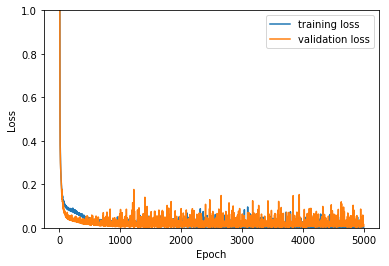

500/500 [==============================] - 0s 48us/sample - loss: 0.0021 - R2: 0.9924
Test Loss: 0.002143
Test R2: 0.9924


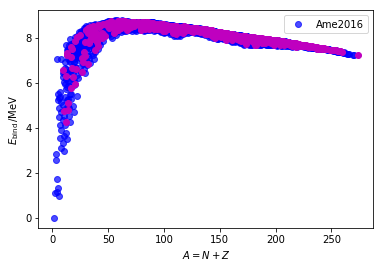

In [20]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx=xx.T
yy = Energies

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xs_train = x_train.astype(np.float64)
xs_test = x_test.astype(np.float64)

xs_train[:,0] = (x_train[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_test[:,0] = (x_test[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_train[:,1] = (x_train[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])
xs_test[:,1] = (x_test[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])

print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(xs_train.shape, xs_train.dtype))
print('Training Targets:\n   Shape: {}\n   Type: {}\n'.format(y_train.shape, y_train.dtype))
print('Test Features:\n   Shape: {}\n   Type: {}\n'.format(xs_test.shape, xs_test.dtype))
print('Test Targets:\n   Shape: {}\n   Type: {}\n'.format(y_test.shape, y_test.dtype))

nodes = 50
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,y_train,epochs=5000, batch_size=16, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, y_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

### Run a little more

If you want to run further epochs with the output model and a starting point, this cell should do it for you

Train on 1597 samples, validate on 400 samples
Epoch 1/20
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0065 - R2: 0.9854 - val_loss: 0.0286 - val_R2: 0.9763
Epoch 2/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0461 - R2: 0.9249 - val_loss: 0.0664 - val_R2: 0.9592
Epoch 3/20
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0179 - R2: 0.9739 - val_loss: 0.0155 - val_R2: 0.9895
Epoch 4/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0092 - R2: 0.9852 - val_loss: 0.0325 - val_R2: 0.9803
Epoch 5/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0049 - R2: 0.9886 - val_loss: 0.0089 - val_R2: 0.9921
Epoch 6/20
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0036 - R2: 0.9884 - val_loss: 0.0144 - val_R2: 0.9891
Epoch 7/20
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0031 - R2: 0.9925 - val_loss: 0.0211 - val_R2: 0.9878
E

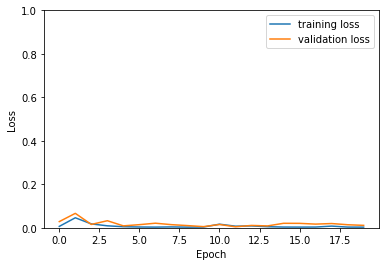

In [9]:
results=model.fit(xs_train,y_train,epochs=20, batch_size=16, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

### Make some predictions

We can, in principle, hand the neural net a N,Z array, and predict binding energies

In [21]:
N=8
Z=8

Zs=(Z - np.average(xx[:,0])) / np.average(xx[:,0])
Ns=(N - np.average(xx[:,1])) / np.average(xx[:,1])

nucleus=np.array([[Zs,Ns]])

[[BE]] = model.predict(nucleus)

print("Binding Energy Per Nucleon: ",BE)
print("Binding Energy: ",BE*(N+Z))

Binding Energy Per Nucleon:  7.6895247
Binding Energy:  123.03239440917969


## Save the model for posterity

Since it takes a long time to train

In [23]:
# This won't overwrite the 'real' trained github file
model.save('neuralmasses_testing.h5')
